In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import shap
from transition_points import find_transition_point
import seaborn as sns
from matplotlib import patheffects

In [2]:
# House keeping
_save_path = os.getcwd() #change to your own path
_dir = os.path.join(_save_path,'California')
os.makedirs(_dir, exist_ok=True)

X, y = shap.datasets.california(n_points=1000) 
data = pd.concat([X.reset_index(drop=True),pd.DataFrame(y,columns=['HousePrice']).reset_index(drop=True)],axis=1)

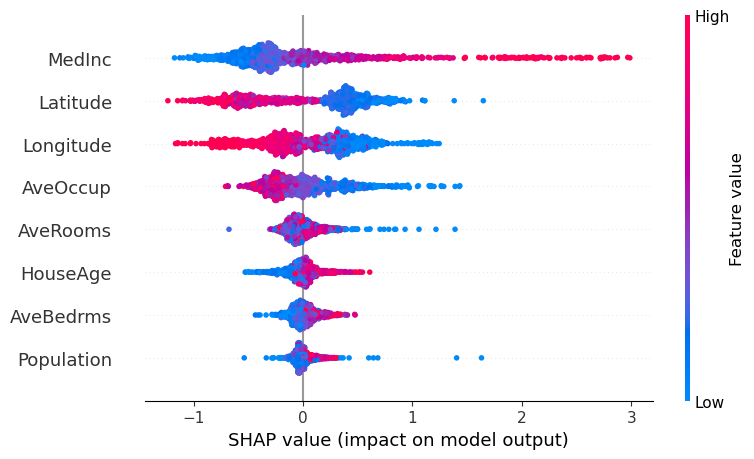

In [3]:
# Train a machine learning model and run SHAP
model = XGBRegressor()
model.fit(X.values, y.astype(int))
explainer = shap.TreeExplainer(model, X)
shap_values = explainer(X) 

shap.summary_plot(shap_values, X)

MedInc


TPE running: 100%|██████████| 20/20 [00:25<00:00,  1.28s/it]

[3.9408325658992323]


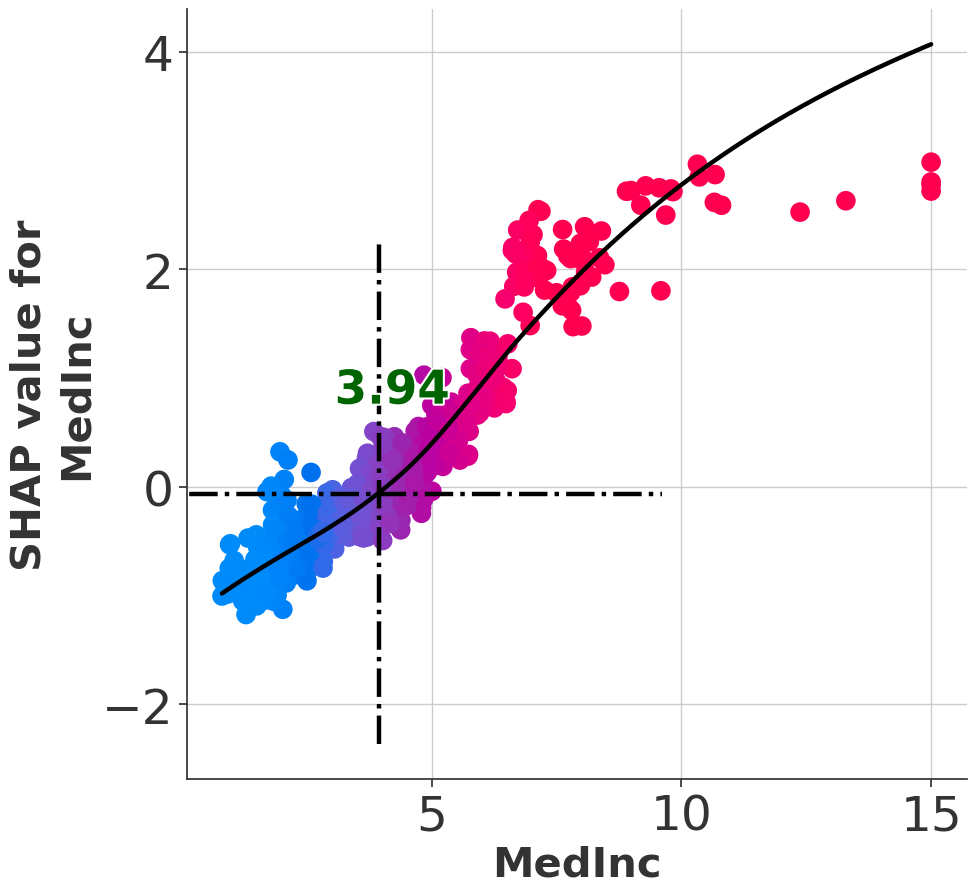

HouseAge


TPE running: 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]

[nan]


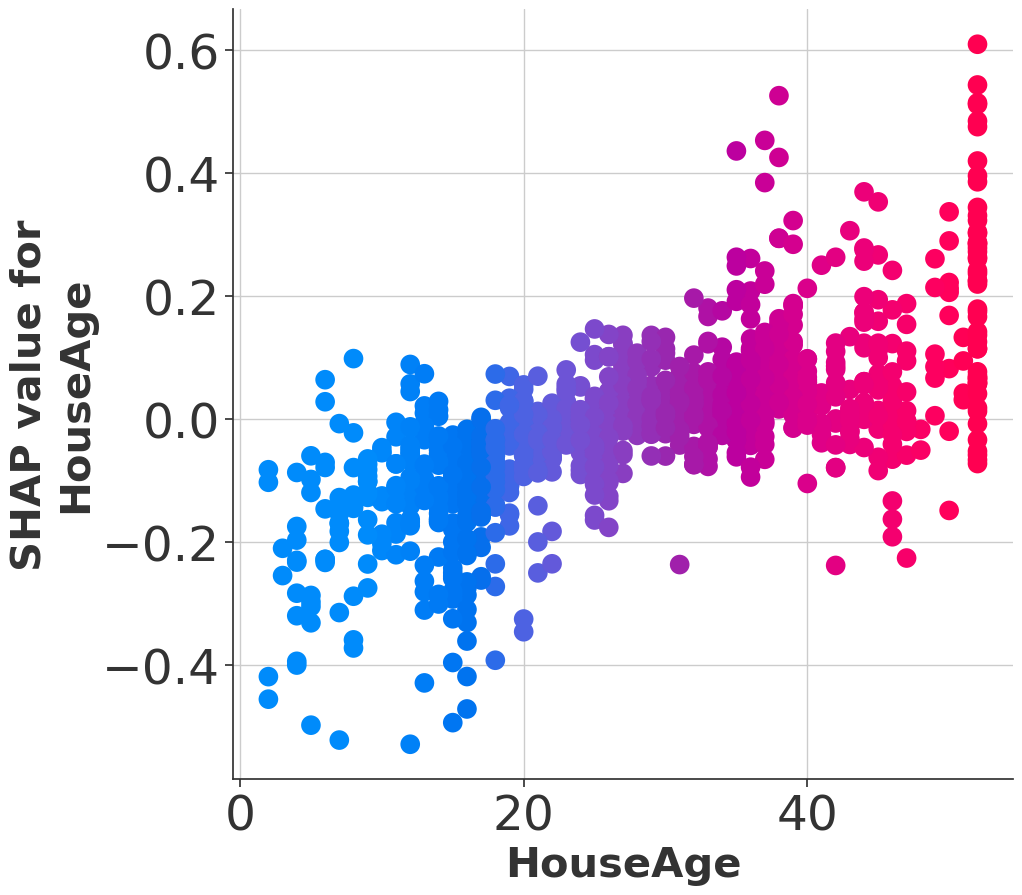

AveRooms


TPE running: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]

[5.82055483116357]


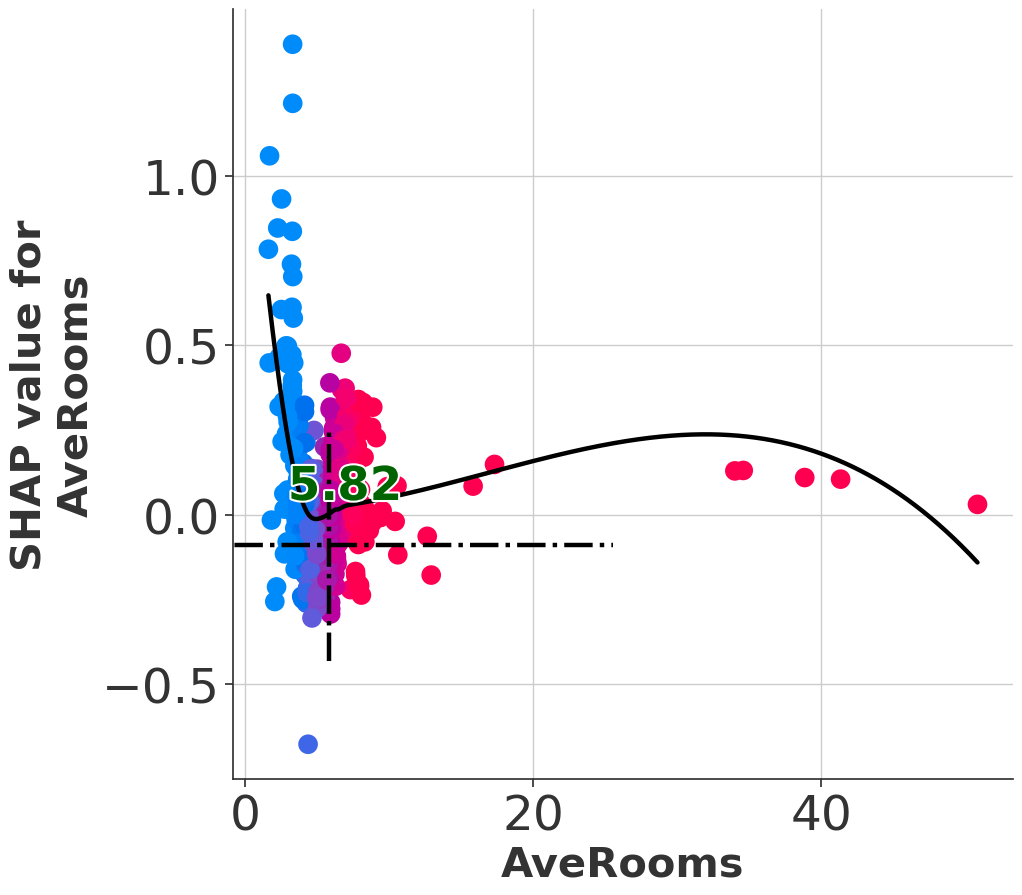

AveBedrms


TPE running: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]

[1.0924541014631106]


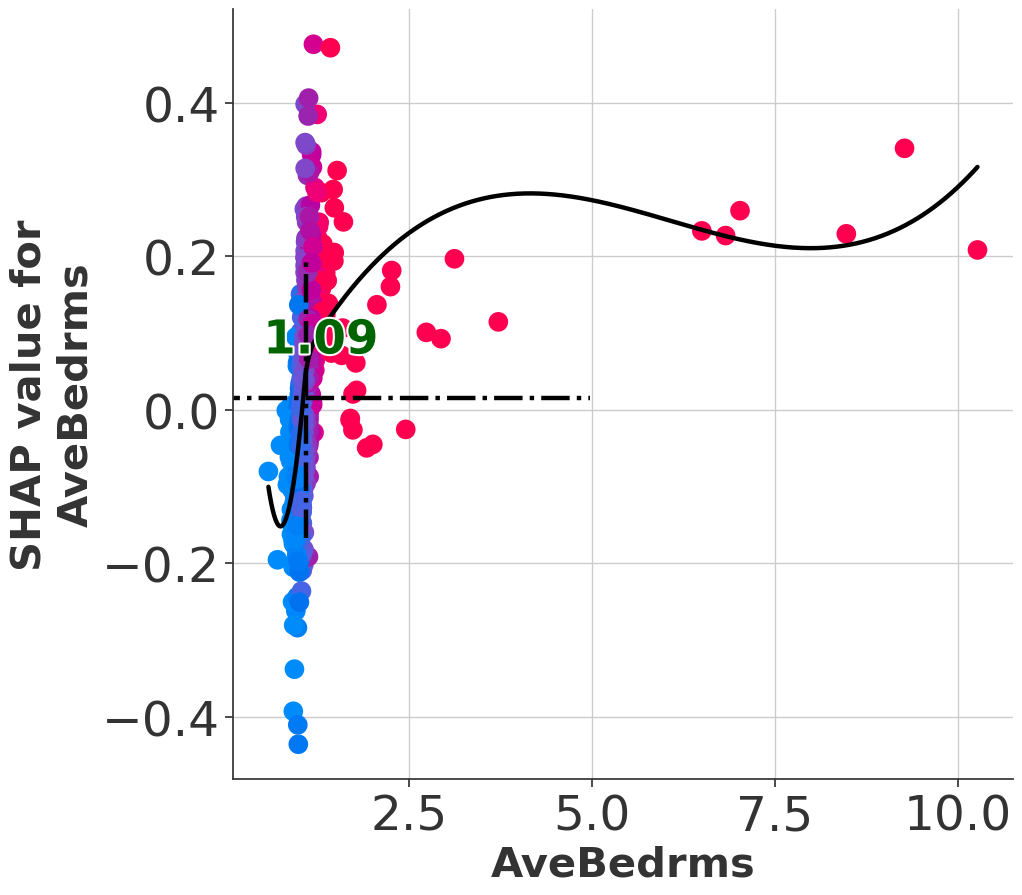

Population


TPE running: 100%|██████████| 20/20 [00:46<00:00,  2.34s/it]

[876.2509175842509]


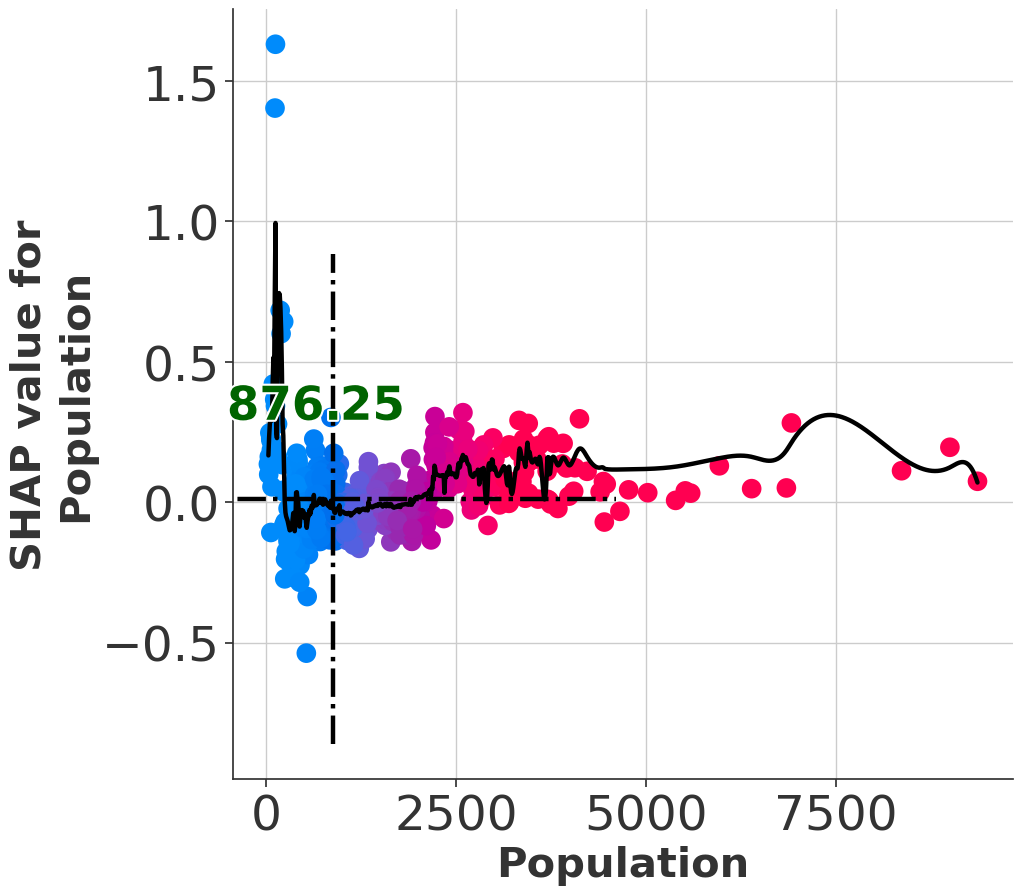

AveOccup


TPE running: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]

[3.015396329978024]


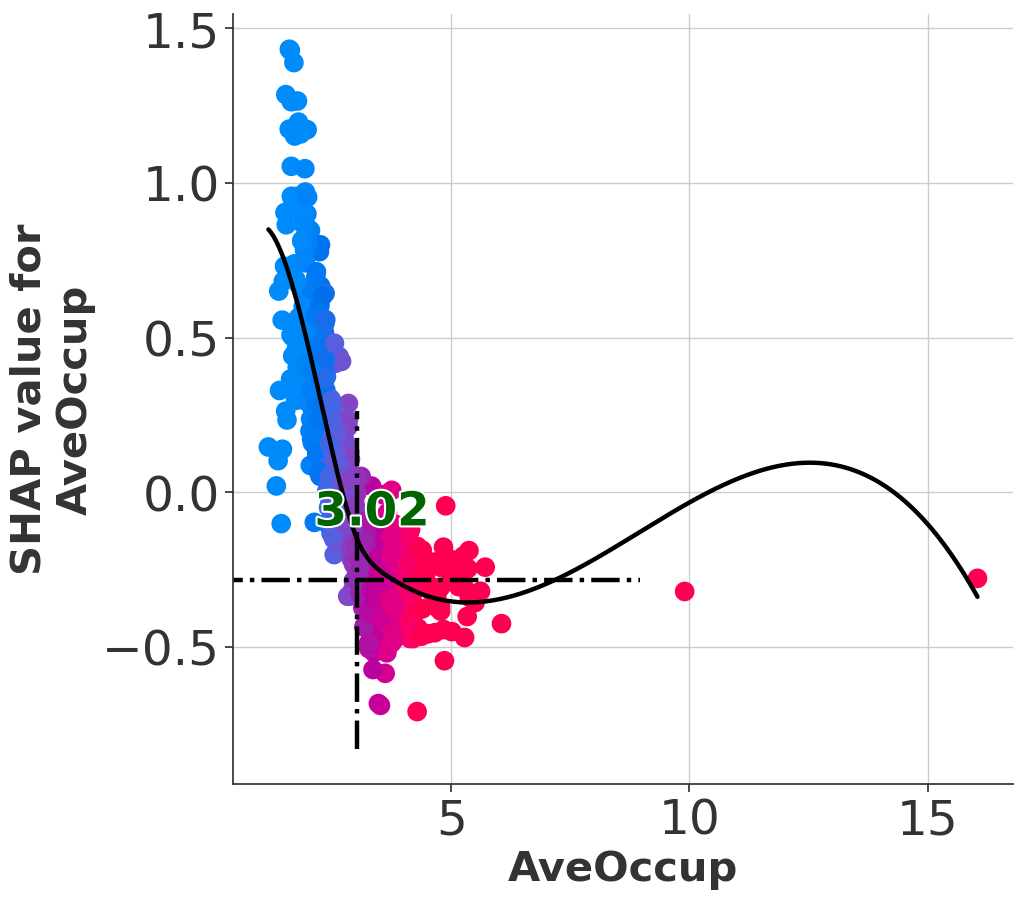

Latitude


TPE running: 100%|██████████| 20/20 [00:33<00:00,  1.66s/it]

[36.38906156156156]


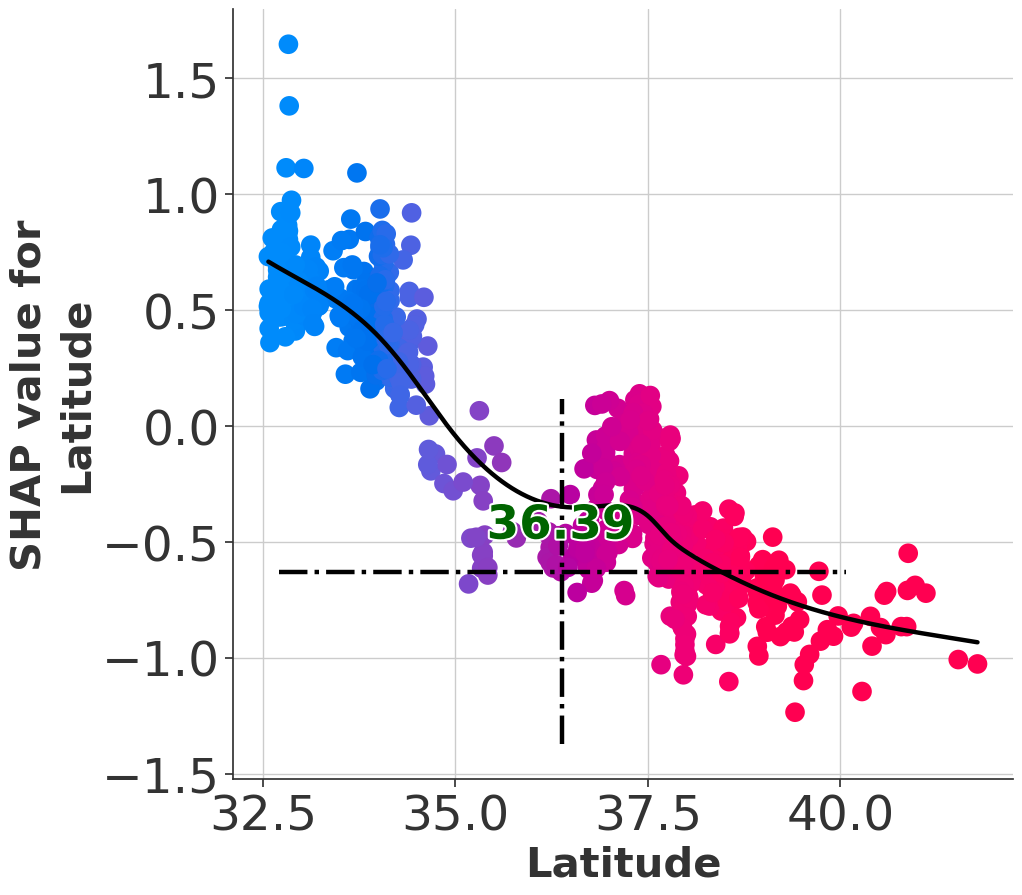

Longitude


TPE running: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

[-119.85338338338339]


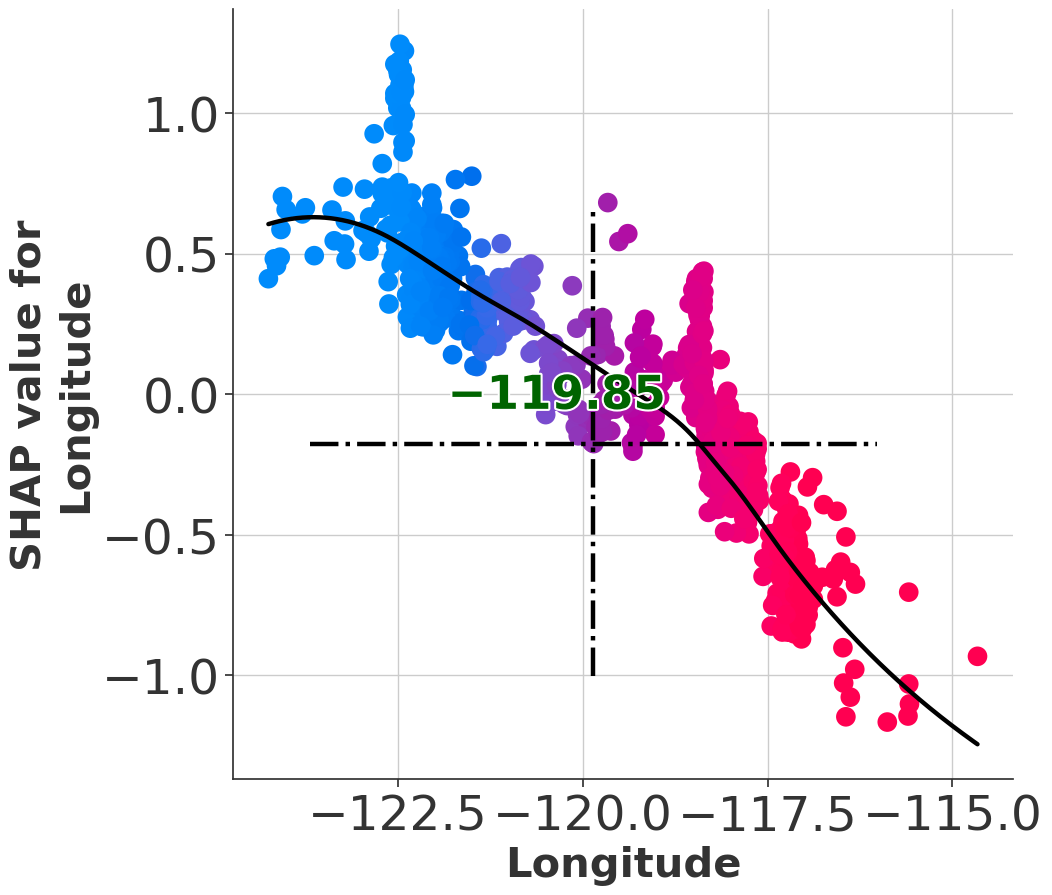

<Figure size 640x480 with 0 Axes>

In [4]:
# Lets run TPE for each feature 
features = list(X.columns)
for i in range(len(features)):
    feature_name = features[i]
    print(feature_name)
    predictor_variable = feature_name
    feature_dir = predictor_variable
    os.makedirs(os.path.join(_save_path, _dir, feature_dir), exist_ok=True)
    inds = shap.approximate_interactions(predictor_variable, shap_values.values, X)
    idx = np.where(X.columns == predictor_variable)[0][0]
    for j in reversed(range(len(features))):
        if idx is not None:
            data = pd.DataFrame({'x_features': X.iloc[:, idx],'y_sv': shap_values.values[:, idx]})

            x_features = data['x_features']
            y_shap_values = data['y_sv']
            #
            plt.close()
            sns.set_theme(style="whitegrid")
            sns.set_context("notebook", font_scale=2.8)
            plt.rcParams["axes.labelweight"] = "bold"

            _, ax = plt.subplots(figsize=(12, 10))
            shap.dependence_plot(predictor_variable, shap_values.values, X, show=False, interaction_index=inds[j],dot_size=200, color=plt.get_cmap("jet"), ax=ax)

            unique_values = np.unique(x_features)
            if len(unique_values) >= 5:
                slope_thresholds = [1e-03]
                matching_thresholds = [1e-1]
                peak_bottom_thresholds = [0.8, 0.9]
                significance_thresholds = [0.05]
                user_defined_s = [0.01, 0.03, 0.04, 0.05, 0.07, 0.09, 0.15, 0.2, 0.4, 1.10]
                user_defined_k = [3]
                
                (   x_smoothed,
                    y_sv_smoothed,
                    x_spline_smooth,
                    y_spline_smooth,
                    transition_point_found,
                    transition_points,
                ) = find_transition_point(
                    x_features,
                    y_shap_values,
                    slope_thresholds,
                    matching_thresholds,
                    peak_bottom_thresholds,
                    significance_thresholds,
                    user_defined_s,
                    user_defined_k,
                    handle_duplicates="median",
                )
                print(transition_points)
                if transition_point_found:
                    transition_y_values = []
                    for x_point in transition_points:
                        index = (np.abs(x_features - x_point)).argmin()
                        if index < len(y_shap_values):
                            transition_y_values.append(y_shap_values.iloc[index])
                        else:
                            print(f"Index out of bounds: {index}")

                    line_length_x = (np.max(x_features) - np.min(x_features)) * 0.8
                    line_length_y = (np.max(y_sv_smoothed) - np.min(y_sv_smoothed)) * 0.9
                    
                    x_spline_smooth = np.nan_to_num(x_spline_smooth, nan=0.0)
                    y_spline_smooth = np.nan_to_num(y_spline_smooth, nan=0.0)
                    ax.plot(x_spline_smooth, y_spline_smooth, color='black', linewidth=3.2)

                    offset_x = (np.max(x_features) - np.min(x_features)) * 0.1  
                    offset_y = np.max(y_sv_smoothed) * 0.2  

                    for i, (x_point, y_point) in enumerate(zip(transition_points, transition_y_values)):
                        plt.hlines(y=y_point, xmin=x_point - line_length_x / 2, xmax=x_point + line_length_x / 2, colors='black', linestyle='-.', linewidth=3.2)
                        plt.vlines(x=x_point, ymin=y_point - line_length_y / 2, ymax=y_point + line_length_y / 2, colors='black', linestyle='-.', linewidth=3.2)
                        point_rounded = np.round(x_point, 2)

                        direction_x = offset_x if i % 2 == 0 else -offset_x
                        direction_y = offset_y if i % 2 == 0 else -offset_y

                        ax.annotate(f"$\mathbf{{{str(point_rounded)}}}$",
                                    xy=(x_point, y_point),
                                    xytext=(x_point + direction_x, y_point + direction_y),
                                    horizontalalignment='right',
                                    color='darkgreen', 
                                    path_effects=[patheffects.withStroke(linewidth=3, foreground="white")])

            ax.xaxis.label.set_size(30)
            ax.yaxis.label.set_size(30)
            ax.tick_params(axis='both', which='major', labelsize=35)
            plt.gcf().subplots_adjust(left=0.25)
            plt.show()
            plt.savefig(os.path.join(_save_path, _dir, feature_dir, predictor_variable + '_' + str(j) + '.png'), dpi=120)
            # plt.close()
            break 